In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
print('Completed importing libraries')

Completed importing libraries


In [ ]:
# Check if a GPU is found
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 32
CHANNELS = 3
# You'll have to upload the .npy file created using the 'prepare_data.py' program onto your Google Drive, mount your Google Drive and set 'DATA_PATH' to the path of that .npy file.
DATA_PATH = '/content/drive/MyDrive/Datasets for Google Colab/data-(64,64,3).npy' 
BUFFER_SIZE = 8000

In [ ]:
# Load the .npy file created using the 'prepare_data.py' program
X = np.load(DATA_PATH)

def preprocess(X):
  """
  Shuffles the data and normalizes the pixel values to the [-1,1] range.
  """
    np.random.shuffle(X)
    X = (X.astype('float32')/255.)*2 - 1
    return X
# Pre-process the data
X_train = preprocess(X)
TRAIN_SET_SIZE = X_train.shape[0]
print('Train Set: {}'.format(X_train.shape))
# Create a TF Dataset. Shuffle, Batch and Prefetch.
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

Train Set: (16185, 64, 64, 3)


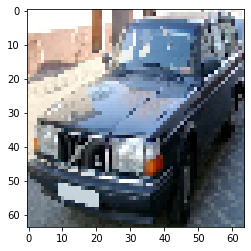

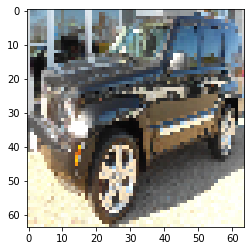

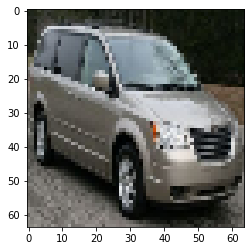

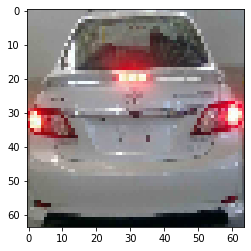

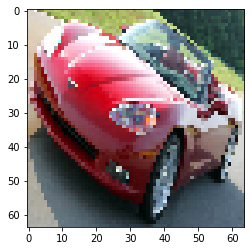

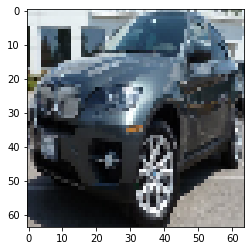

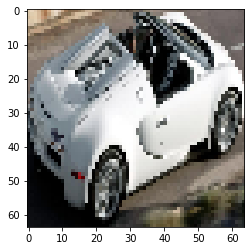

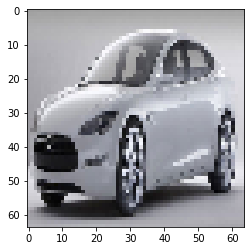

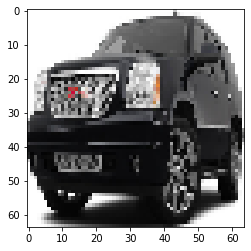

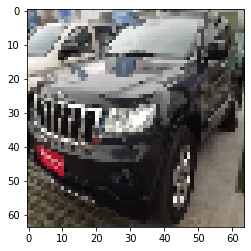

In [ ]:
# Visualize the images in the dataset
for i in range(10):
    plt.imshow(((X_train[i]+1)/2)[:, :, ::-1])
    plt.show()

In [ ]:
# MODEL ARCHITECTURE

# Latent Vector's Dimension/Size
latent_dim = 100
# Generator
generator = keras.models.Sequential([
  keras.layers.Dense(4 * 4 * 256, input_shape=[latent_dim]),
  keras.layers.Reshape((4, 4, 256)),

  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(256, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.Activation('relu'),

  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(256, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.Activation('relu'),

  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(128, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.Activation('relu'),

  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(128, kernel_size=3, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.Activation('relu'),

  keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'),
])
# Discriminator
discriminator = keras.models.Sequential([
  keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=[IMG_SIZE, IMG_SIZE, CHANNELS]),
  keras.layers.LeakyReLU(alpha=0.2),
  keras.layers.Dropout(0.25),

  keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
  keras.layers.ZeroPadding2D(padding=((0,1),(0,1))),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.LeakyReLU(alpha=0.2),
  keras.layers.Dropout(0.25),

  keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.LeakyReLU(alpha=0.2),
  keras.layers.Dropout(0.25),

  keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.LeakyReLU(alpha=0.2),
  keras.layers.Dropout(0.25),

  keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same'),
  keras.layers.BatchNormalization(momentum=0.8),
  keras.layers.LeakyReLU(alpha=0.2),
  keras.layers.Dropout(0.25),

  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid'),                                         
])
# DCGAN model
dcgan = keras.models.Sequential([generator, discriminator])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 17, 17, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 17, 17, 64)       

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam') # Set the loss function and optimizer for the discriminator
discriminator.trainable = False  # Freeze the weights of the discriminator model (needed to train the Generator)
dcgan.compile(loss='binary_crossentropy', optimizer='adam') # Set the loss function and optimizer for the DCGAN model

In [ ]:
def format_time(total_seconds):
  """
  Creates a string that formats the time into a 'hours:minutes:seconds' format
  """
  h = int(total_seconds / (60 * 60))
  m = int((total_seconds % (60 * 60)) / 60)
  s = total_seconds % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def generate_images(num_imgs):
  """
  Samples 'num_imgs' random points from a Gaussian distribution, passes them to the Generator to generate 'num_imgs' corresponding images, and plots them
  (5 per row)
  """
  random_latent_vectors = tf.random.normal(shape=[num_imgs, latent_dim])
  generated_images = generator(random_latent_vectors)
  generated_images.numpy()

  columns = 5
  rows = num_imgs//columns
  plt.figure(figsize=(columns * 3, rows * 3))
  for row in range(rows):
      for col in range(columns):
          index = columns * row + col
          plt.subplot(rows, columns, index + 1)
          plt.imshow(((generated_images[index]+1)/2)[:,:,::-1], interpolation="nearest")
          plt.axis('off')
          
  plt.subplots_adjust(wspace=0.2, hspace=0.5)
  plt.show()

def train(dcgan, dataset, batch_size, latent_dim, num_epochs):
  """
  Given the DCGAN model, the dataset and a few hyperparameters, this function trains the DCGAN on the dataset for 'num_epochs' epochs, 
  displaying 5 generated images every 5 epochs (to show the user how much progress is being made).
  """
  generator, discriminator = dcgan.layers
  for epoch in range(num_epochs):
    epoch_start = time.time()
    for X_batch in dataset:
      # Train the Discriminator
      noise = tf.random.normal(shape=[batch_size, latent_dim])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]]*batch_size + [[1.]]*batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)

      # Train the Generator
      noise = tf.random.normal(shape=[batch_size, latent_dim])
      y2 = tf.constant([[1.]]*batch_size)
      discriminator.trainable = False
      dcgan.train_on_batch(noise, y2)
    epoch_runtime = time.time()-epoch_start
    print('Epoch {}/{}'.format(epoch+1, num_epochs), '\t', format_time(epoch_runtime))
    
    if (epoch + 1)%5 == 0:  # Generate 5 random images every 5 epochs & display them
      generate_images(5) 
    if (epoch + 1)%50 == 0: # Save the model after every 50 epochs
      dcgan.save('DCGAN_v1_trained_for_{}_epochs.h5'.format(epoch+1))



Epoch 1/100 	 0:01:36.84
Epoch 2/100 	 0:01:04.72
Epoch 3/100 	 0:01:03.70
Epoch 4/100 	 0:01:04.47
Epoch 5/100 	 0:01:05.02


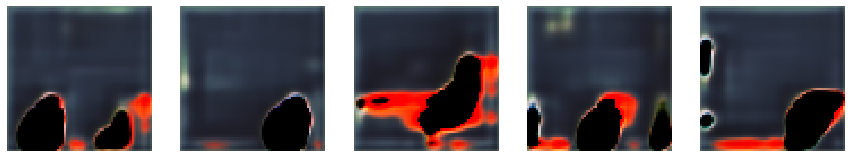

Epoch 6/100 	 0:01:05.29
Epoch 7/100 	 0:01:04.67
Epoch 8/100 	 0:01:05.13
Epoch 9/100 	 0:01:04.94
Epoch 10/100 	 0:01:04.45


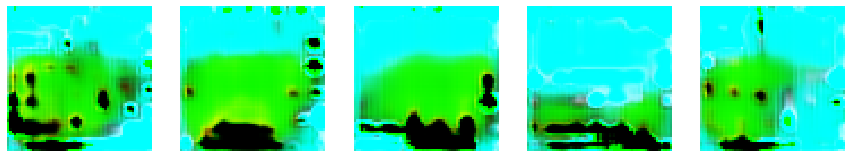

Epoch 11/100 	 0:01:04.76
Epoch 12/100 	 0:01:04.86
Epoch 13/100 	 0:01:04.36
Epoch 14/100 	 0:01:03.68
Epoch 15/100 	 0:01:04.37


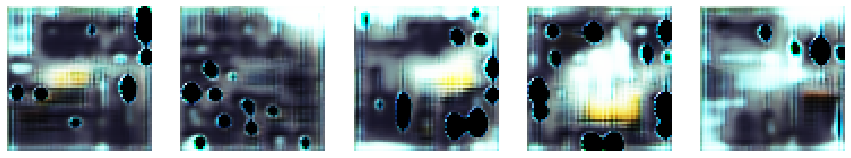

Epoch 16/100 	 0:01:04.98
Epoch 17/100 	 0:01:04.84
Epoch 18/100 	 0:01:05.89
Epoch 19/100 	 0:01:05.48
Epoch 20/100 	 0:01:04.76


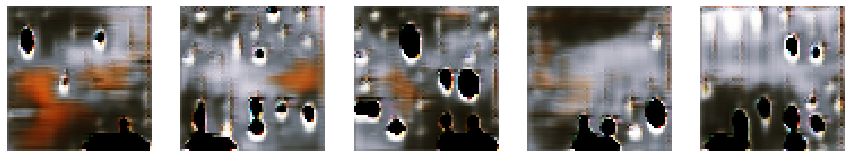

Epoch 21/100 	 0:01:04.75
Epoch 22/100 	 0:01:04.60
Epoch 23/100 	 0:01:04.58
Epoch 24/100 	 0:01:04.17
Epoch 25/100 	 0:01:04.22


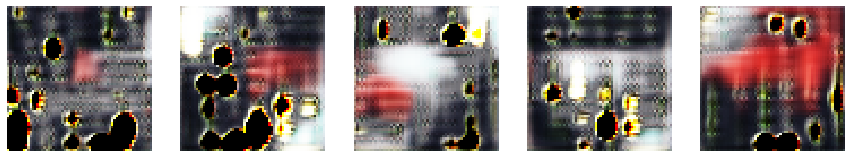

Epoch 26/100 	 0:01:04.05
Epoch 27/100 	 0:01:04.19
Epoch 28/100 	 0:01:04.34
Epoch 29/100 	 0:01:03.98
Epoch 30/100 	 0:01:04.21


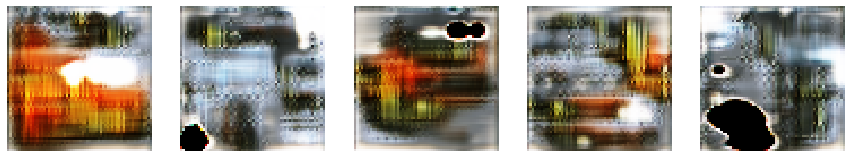

Epoch 31/100 	 0:01:04.76
Epoch 32/100 	 0:01:04.35
Epoch 33/100 	 0:01:04.85
Epoch 34/100 	 0:01:04.79
Epoch 35/100 	 0:01:04.39


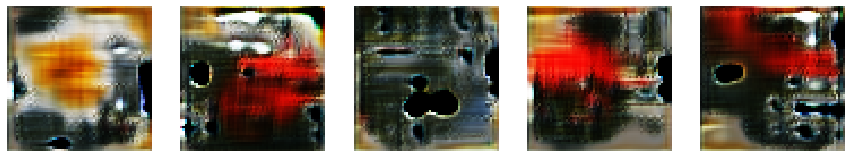

Epoch 36/100 	 0:01:04.70
Epoch 37/100 	 0:01:04.86
Epoch 38/100 	 0:01:05.28
Epoch 39/100 	 0:01:05.13
Epoch 40/100 	 0:01:05.22


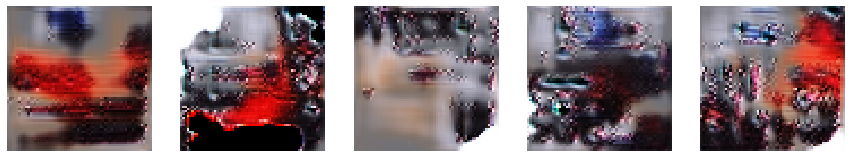

Epoch 41/100 	 0:01:05.14
Epoch 42/100 	 0:01:22.36
Epoch 43/100 	 0:01:05.34
Epoch 44/100 	 0:01:05.01
Epoch 45/100 	 0:01:05.12


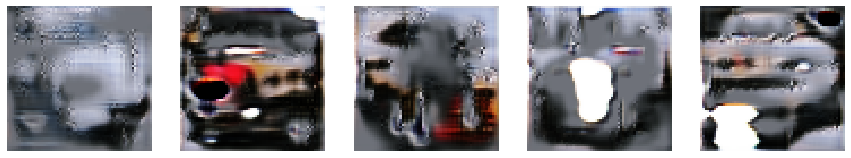

Epoch 46/100 	 0:01:04.66
Epoch 47/100 	 0:01:05.37
Epoch 48/100 	 0:01:04.78
Epoch 49/100 	 0:01:05.88
Epoch 50/100 	 0:01:05.82


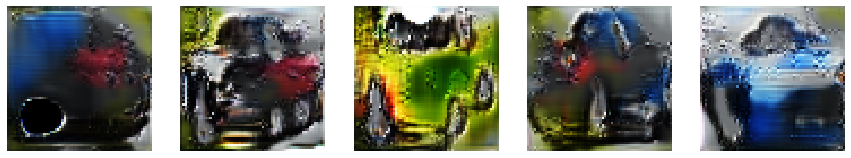

Epoch 51/100 	 0:01:05.71
Epoch 52/100 	 0:01:05.41
Epoch 53/100 	 0:01:05.85
Epoch 54/100 	 0:01:05.53
Epoch 55/100 	 0:01:05.91


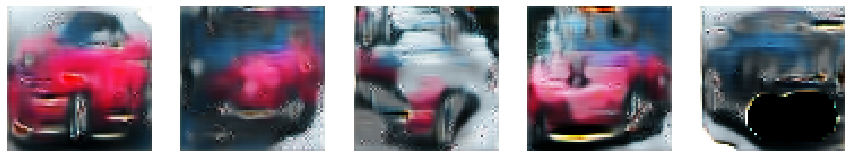

Epoch 56/100 	 0:01:05.57
Epoch 57/100 	 0:01:06.12
Epoch 58/100 	 0:01:05.69
Epoch 59/100 	 0:01:05.80
Epoch 60/100 	 0:01:05.54


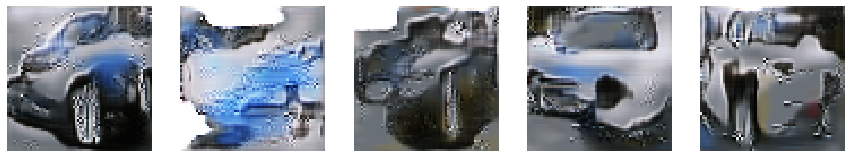

Epoch 61/100 	 0:01:05.78
Epoch 62/100 	 0:01:05.39
Epoch 63/100 	 0:01:05.51
Epoch 64/100 	 0:01:04.95
Epoch 65/100 	 0:01:04.81


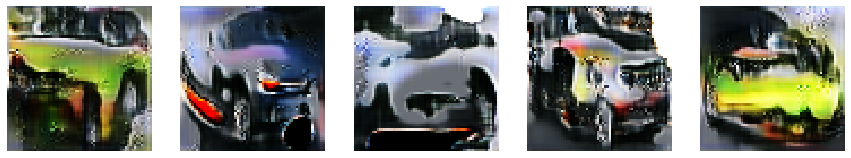

Epoch 66/100 	 0:01:04.90
Epoch 67/100 	 0:01:04.98
Epoch 68/100 	 0:01:05.00
Epoch 69/100 	 0:01:05.42
Epoch 70/100 	 0:01:05.53


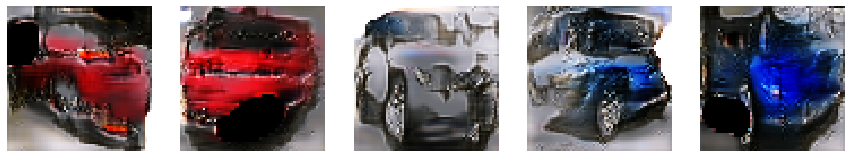

Epoch 71/100 	 0:01:05.93
Epoch 72/100 	 0:01:05.97
Epoch 73/100 	 0:01:05.91
Epoch 74/100 	 0:01:06.01
Epoch 75/100 	 0:01:06.12


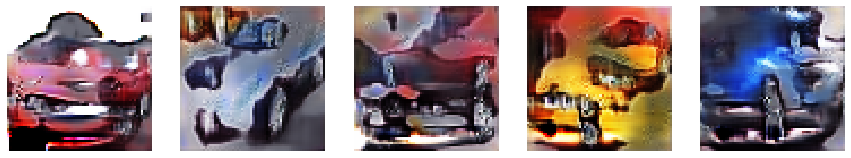

Epoch 76/100 	 0:01:05.73
Epoch 77/100 	 0:01:05.10
Epoch 78/100 	 0:01:05.27
Epoch 79/100 	 0:01:05.01
Epoch 80/100 	 0:01:06.45


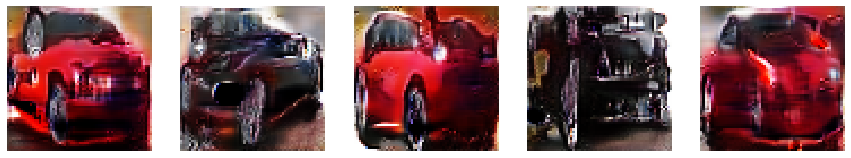

Epoch 81/100 	 0:01:05.80
Epoch 82/100 	 0:01:05.80
Epoch 83/100 	 0:01:06.32
Epoch 84/100 	 0:01:05.68
Epoch 85/100 	 0:01:06.02


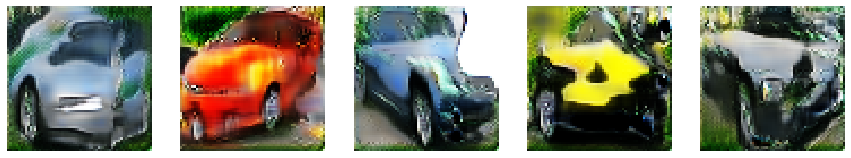

Epoch 86/100 	 0:01:05.61
Epoch 87/100 	 0:01:05.18
Epoch 88/100 	 0:01:05.07
Epoch 89/100 	 0:01:04.98
Epoch 90/100 	 0:01:05.55


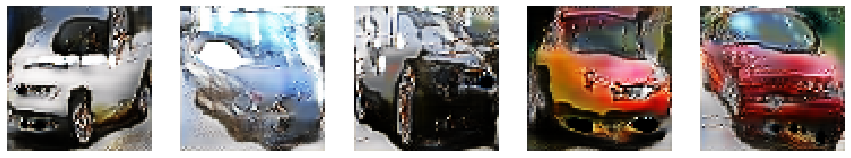

Epoch 91/100 	 0:01:05.89
Epoch 92/100 	 0:01:06.03
Epoch 93/100 	 0:01:05.28
Epoch 94/100 	 0:01:05.81
Epoch 95/100 	 0:01:05.39


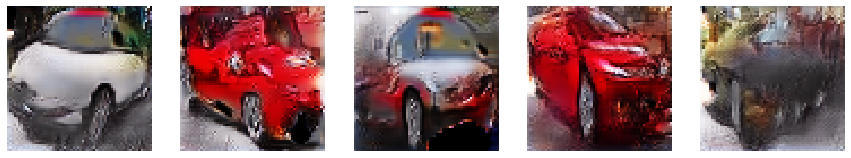

Epoch 96/100 	 0:01:05.93
Epoch 97/100 	 0:01:05.49
Epoch 98/100 	 0:01:05.16
Epoch 99/100 	 0:01:05.11
Epoch 100/100 	 0:01:05.85


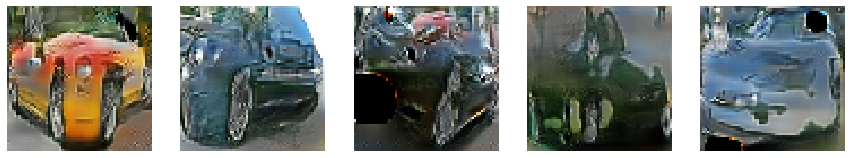

In [ ]:
# Train the DCGAN model
tf.config.run_functions_eagerly(True)
train(dcgan, dataset, BATCH_SIZE, latent_dim, num_epochs=100)

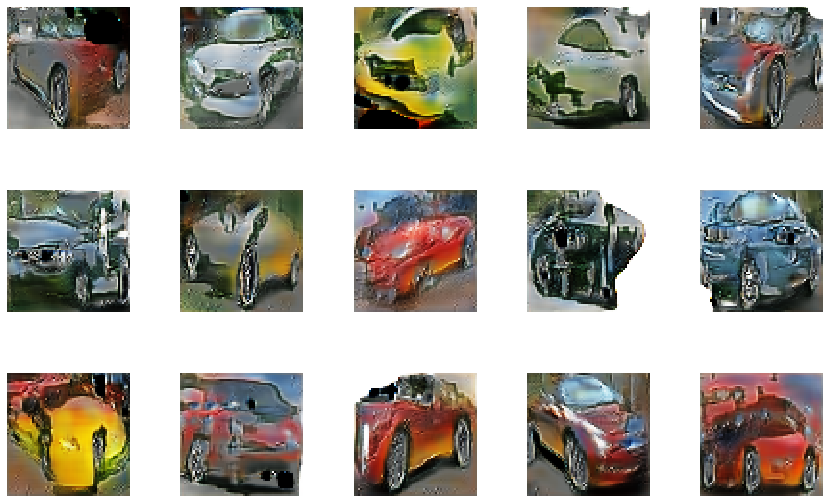

In [ ]:
# Random images generated by the DCGAN
generate_images(15)